In [1]:
# pip install openpyxl
# pip install conjugate-prior
from conjugate_prior import GammaPoisson
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy.stats import gamma, poisson, nbinom, truncnorm
from scipy.special import softmax
from statsmodels.stats.outliers_influence import variance_inflation_factor
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)


# Úloha 1

## Konjugované apriorní a aposteriorní rozdělení, prediktivní rozdělení

### Načtení dat

In [2]:
data_task1a = pd.read_excel('Projekt-2_Data.xlsx')
print(data_task1a)


       uloha_1 a)  uloha_1 b)_prior  skupina  uloha_1 b)_pozorování
0             2.0          3.634785        0               3.626656
1             2.0          2.868113        0               3.008269
2             1.0          2.149160        0               2.989829
3             3.0          4.263065        0               2.371630
4             0.0          2.594745        0               4.009366
...           ...               ...      ...                    ...
99995         NaN          1.725637     9999                    NaN
99996         NaN          4.048414     9999                    NaN
99997         NaN          3.000662     9999                    NaN
99998         NaN          3.058451     9999                    NaN
99999         NaN          4.487418     9999                    NaN

[100000 rows x 4 columns]


Z expertního odhadu víme, že každou 5 ms dojde k 10 připojením. Expertní odhad parametru lambda je tedy roven 2.

Z tabulek (https://en.wikipedia.org/wiki/Conjugate_prior) vidíme, že konjugované apriorní rozdělení je Gamma rozdělení s parametry 'k' a 'lambda'.

### Výpočet pomocí knihovny

Hlavní výpočet je v následující podsekci, zde pouze demonstrace fungování knihovny conjugate_prior.

Assuming first parameter is the Expectancy


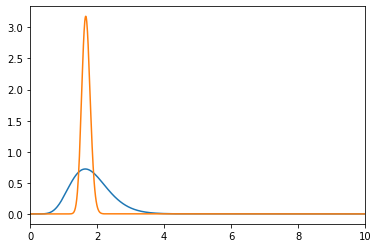

In [3]:
alpha = 10 
beta = 5 
prior_model = GammaPoisson(alpha)
updated_model = prior_model.update(alpha, beta)
updated_model.plot()

posterior = updated_model.update(data_task1a["uloha_1 a)"].dropna())
posterior.plot()

### Manuální výpočet

**Úloha 1-a-1**

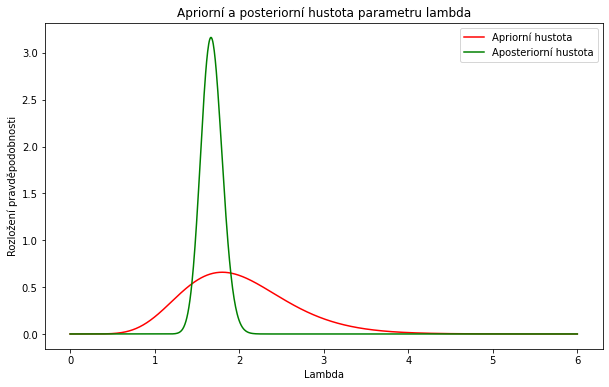

In [4]:
# filtrovana data (bez NaN hodnot)
filtered_data_task1a = data_task1a["uloha_1 a)"].dropna()

# prior parametry
alpha_prior = 10.0
beta_prior = 5.0

# posterior parametry (viz tabulka https://en.wikipedia.org/wiki/Conjugate_prior)
alpha_posterior = alpha_prior + filtered_data_task1a.sum()
beta_posterior = beta_prior + len(filtered_data_task1a)

# rozsah lambda hodnot
lambdas = np.linspace(0, filtered_data_task1a.max()+1, 1000) # 1000 bodu mezi 0 a max hodnotou+1

# pravdepodobnostni funkce
prior = gamma.pdf(lambdas, alpha_prior, scale=1/beta_prior)
posterior = gamma.pdf(lambdas, alpha_posterior, scale=1/beta_posterior)

# vykresleni
plt.figure(figsize=(10, 6))
plt.plot(lambdas, prior, label='Apriorní hustota', color='red')
plt.plot(lambdas, posterior, label='Aposteriorní hustota', color='green')
plt.legend()
plt.title('Apriorní a posteriorní hustota parametru lambda')
plt.xlabel('Lambda')
plt.ylabel('Rozložení pravděpodobnosti')
plt.show()

**Úloha 1-a-2**

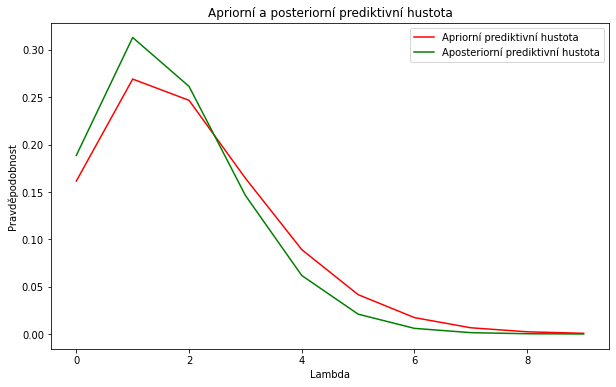

In [5]:
# vyuzijeme parametru z predchoziho kroku pro vypocet parametru prediktivni hustoty (prior i posterior)
# vyuzijeme binomialniho rozdeleni (prepis vzorce)
# prior parametry
binomial_alpha_prior = alpha_prior
binomial_beta_prior = beta_prior/(1+beta_prior)

# posterior parametry
binomial_alpha_posterior = alpha_posterior
binomial_beta_posterior = beta_posterior/(1+beta_posterior)

x_values = np.arange(0, filtered_data_task1a.max()+5) # experimentalne nastaveno na 5, aby byl videt "ocas"

predictive_probs_prior = nbinom.pmf(x_values, binomial_alpha_prior, binomial_beta_prior)
predictive_probs_posterior = nbinom.pmf(x_values, binomial_alpha_posterior, binomial_beta_posterior)

plt.figure(figsize=(10, 6))
plt.plot(x_values, predictive_probs_prior, label='Apriorní prediktivní hustota', color='red')
plt.plot(x_values, predictive_probs_posterior, label='Aposteriorní prediktivní hustota', color='green')
plt.title('Apriorní a posteriorní prediktivní hustota')
plt.xlabel('Lambda')
plt.ylabel('Pravděpodobnost')
plt.legend()
plt.show()

**Úloha 1-a-3**

In [6]:
# interval spolehlivosti pro parametr lambda z apriorního a aposteriorního rozdělení
lambda_prior_low = gamma.ppf(0.025, a=alpha_prior, scale=1/beta_prior)
lambda_prior_high = gamma.ppf(0.975, a=alpha_prior, scale=1/beta_prior)

lambda_posterior_low = gamma.ppf(0.025, a=alpha_posterior, scale=1/beta_posterior)
lambda_posterior_high = gamma.ppf(0.975, a=alpha_posterior, scale=1/beta_posterior)

print(f"95% interval spolehlivosti pro parametr lambda z apriorního rozdělení: <{round(lambda_prior_low, 5)}, {round(lambda_prior_high, 5)}>")
print(f"95% interval spolehlivosti pro parametr lambda z aposteriorního rozdělení: <{round(lambda_posterior_low, 5)}, {round(lambda_posterior_high, 5)}>")

95% interval spolehlivosti pro parametr lambda z apriorního rozdělení: <0.95908, 3.41696>
95% interval spolehlivosti pro parametr lambda z aposteriorního rozdělení: <1.43769, 1.93272>


**Porovnání**: 

Z intervalů vidíme, že z apriorního rozdělení získáváme mnohem širší interval možných hodnot, kdežto v případě aposteriorního je interval se stejnou spolehlivostí značně užší. 
Obecně platí, že apriorní rozložení je založeno na nějaké expertní informaci, aniž bychom pozorovali data. Aposteriorní rozložení pak bere v potaz jak expertní informaci, tak skutečně naměřená data. U výsledků tedy dává smysl, že před zahrnutím skutečně naměřených hodnot je interval širší (více možných hodnot parametru), až po započítání skutečných hodnot získáváme užší, přesnější interval. 

**Úloha 1-a-4**

In [7]:
# bodove odhady parametru lambda
mean_estimate = alpha_posterior/beta_posterior                              # prumer
median_estimate = gamma.median(a=alpha_posterior, scale=1/beta_posterior)   # stredni hodnota (stred intervalu)

print(f"Bodový odhad parametru lambda za použití střední hodnoty: {mean_estimate:.5f}")
print(f"Bodový odhad parametru lambda za použití mediánu: {median_estimate:.5f}")

Bodový odhad parametru lambda za použití střední hodnoty: 1.67619
Bodový odhad parametru lambda za použití mediánu: 1.67302


**Komentář k výběru a porovnání:**

Jako bodové odhady lze zvolit průměr, medián, příp. modus. Platí-li, že jsou data nevychýlená, tyto 3 hodnoty by se měly rovnat. 
Obecně platí, že průměr je citlivý na extrémní hodnoty. Výhodou je, že zahrnuje všechny hodnoty, což se nám hodí v případě, kdy máme důvěru v rozumné modelování a nemáme silné důvody některým hodnotám nevěřit.
Medián odpovídá střední hodnotě intervalu a na rozdíl od průměru je odolnější vůči extrémním hodnotám a ukazuje hodnotu, pod kterou a nad kterou leží stejné procento dat (tj. jedná se o 50. percentil). V případě výraznějších odchylek od normálního rozdělení může medián sloužit jako lepší ukazatel střední hodnoty než průměr. 
V našem případě však vidíme, že hodnoty obou bodových odhadů jsou velmi podobné, a tedy lze předpokládat, že data nijak vychýlená nebudou.


**Úloha 1-a-5**

In [8]:
# bodovy odhad prumeru a medianu z apriorniho pravdepodobnostniho rozdeleni (binomicka distribuce)
# prumer z binomickeho rozdeleni = (r(1-p))/p (https://en.wikipedia.org/wiki/Negative_binomial_distribution)
def mean_binomial(r, p):
    return (r*(1.0-p))/p

# apriorni prumer
mean_estimate_prior = mean_binomial(binomial_alpha_prior, binomial_beta_prior)

# apriorni median
# median_estimate_prior = nbinom.median(binomial_alpha_prior, binomial_beta_prior)

# bodovy odhad prumeru a medianu z aposteriorniho pravdepodobnostniho rozdeleni (binomicka distribuce)
# aposteriorni prumer
mean_estimate_posterior = mean_binomial(binomial_alpha_posterior, binomial_beta_posterior)

# aposteriorni median
# median_estimate_posterior = nbinom.median(binomial_alpha_posterior, binomial_beta_posterior)

print(f"Bodový odhad parametru lambda za použití průměru z apriorního pravděpodobnostního rozdělení: {mean_estimate_prior:.5f}")
print(f"Bodový odhad parametru lambda za použití průměru z aposteriorního pravděpodobnostního rozdělení: {mean_estimate_posterior:.5f}\n")
# print(f"Bodový odhad parametru lambda za použití mediánu z apriorního pravděpodobnostního rozdělení: {median_estimate_prior:.5f}")
# print(f"Bodový odhad parametru lambda za použití mediánu z aposteriorního pravděpodobnostního rozdělení: {median_estimate_posterior:.5f}")


Bodový odhad parametru lambda za použití průměru z apriorního pravděpodobnostního rozdělení: 2.00000
Bodový odhad parametru lambda za použití průměru z aposteriorního pravděpodobnostního rozdělení: 1.67619



**Porovnání:**

Bodový odhad lambda za použití průměru vyšel 2, což by nemělo být překvapením, neboť ze zadání víme, že za 5 ms dojde k 10 připojením, tj. za 1 ms dojde ke 2 připojením (náš výsledek). Tento odhad však nezahrnuje skutečná data, se kterými získáváme výsledek 1,67. Z toho můžeme odvodit, že v naměřených datech došlo za 1 ms průměrně k menšímu počtu připojení než 2. Pro ilustraci v grafu níže vidíme celkové zastoupení jednotlivých hodnot parametru lambda. *Zakomentovaný kód by pak ukazoval výsledky mediánu, zadání však vyžadovalo pouze jeden bodový odhad z apriorního a aposteriorního rozdělení.*

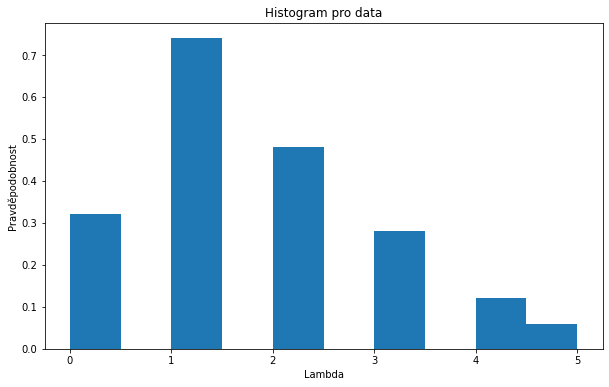

In [9]:
plt.figure(figsize=(10, 6))
plt.hist(filtered_data_task1a, density=True)
plt.title('Histogram pro data')
plt.xlabel('Lambda')
plt.ylabel('Pravděpodobnost')
plt.show()

## Aproximace diskrétním rozdělením

**Úloha 1-b-1**

Tu sme mali viacero problémov. Prvý bol s tvorbou apriórneho rozdelenia pre parameter
"b". Postup, ktorí väčšina z nás zvolila bol nasledujúci:
V každej skupine (z 10 000 skupín, kde každá mala 10 nameraných hodnôt) sme našli
najväčšiu hodnotu. Týchto 10 000 hodnôt sme dali do jednej dátovej sady a vytvorili sme z
nich diskrétne rozdelenie. Toto diskrétne rozdelenie bolo urobené rozdelením všetkých 10
000 hodnôt na intervaly. (Napríklad celý interval hodnôt rozdelíme na 50 intervalov o
rovnakej šírke). Takto bolo získané (žlté) diskrétne apriórne rozdelenie uložené v obrázku
"output.png" v prílohe tohto mailu. Každému intervalu vieme dať "predstaviteľa", t.j.
napríklad stred daného intervalu. Týmto získame diskrétne rozdelenie, ktoré má 50 možných
vstupov, t.j. 50 rôznych parametrov "b" (stredy intervalov) s rôznymi pravdepodobnosťami.

In [10]:
# nacteni dat
data_task1b = pd.read_excel('Projekt-2_Data.xlsx')
data_task1b_observations = data_task1b["uloha_1 b)_pozorování"].dropna()

# nalezneme maxima pro každou skupinu
data_task1b = data_task1b.iloc[:, [1,2]] # skupina a uloha_1 b)_pozorovani
data_task1b_max_value = pd.DataFrame({k: [max(v)] for k, v in data_task1b.groupby("skupina")["uloha_1 b)_prior"]})


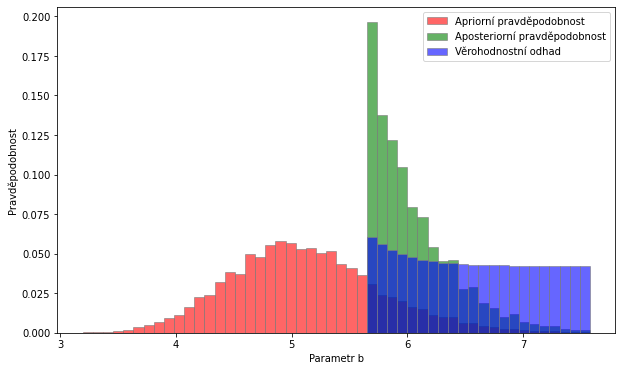

In [11]:
# provedeme binning dat (rozdeleni do skupin)
# aktualne mame 100 000/10 = 10 000 hodnot, ktere rozdelime do 50 kosu (binu)
# maximalni hodnoty rozradime do binu o stejne sirce, navratova hodnota je: pocet hodnot v binu, hranice binu (prava)
num_of_values_in_bin, bins_edges = np.histogram(data_task1b_max_value, bins=50)
prior_prob = num_of_values_in_bin/num_of_values_in_bin.sum() # normalizace, abychom ziskali pravdepodobnosti (apriorni)

# vypocteme "reprezentanta" z kazdeho intervalu (stred intervalu)
# takto ziskame diskretni rozdeleni, ktere ma 50 moznych vstupu (50 ruznych parametru b s ruznymi pravdepodobnostmi)
bins_centers = bins_edges[:-1] + np.diff(bins_edges)/2

likelihood_estimate = []

# vime, ze delka zpracovani procesu v milisekundach ma odseknute normalni rozdeleni (truncated normal distribution)
    # tzn. rozdeleni je normalni, ale jen v urcitem rozsahu
# pro kazdy parametr b (vsech 50) ziskame pravdepodobnost (v log domene), ktera nam rika, jak je pravdepodobne, ze hodnota b je spravna
# tuto pravdepodobnostni funkci nasledne pouzijeme pro vypocet aposteriorni pravdepodobnosti
mu = 3
sigma = 1
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.truncnorm.html
for bin in bins_centers:
    likelihood_estimate.append(np.sum(truncnorm(a=(1-mu)/sigma, b=(bin-mu)/sigma, loc=mu, scale=sigma).logpdf(data_task1b_observations)))

# hodnoty likelihood jsou v log domene, potrebujeme rozsah <0,1>, vyuzijeme soft-max funkci, ktera ma vystup v pozadovanem rozsahu <0,1>
likelihood_probs = softmax(likelihood_estimate)

# "tabulkova metodu" pri diskretni promenne pro vypocet posterior pravdepodobnosti jako na cviceni
posterior_estimate = prior_prob*likelihood_probs                # apriorni pravdepodobnost * verohodnostní odhad (vaha)
posterior_probs = posterior_estimate/posterior_estimate.sum()   # normalizace (abychom dostali pravdepodobnosti, tj. rozsah <0,1>)

plt.figure(figsize=(10, 6))
plt.hist(bins_edges[:-1], bins_edges, weights=prior_prob, label='Apriorní pravděpodobnost', alpha=0.6, color='red', edgecolor='grey')
plt.hist(bins_edges[:-1], bins_edges, weights=posterior_probs, label='Aposteriorní pravděpodobnost', alpha=0.6, color='green', edgecolor='grey')
plt.hist(bins_edges[:-1], bins_edges, weights=likelihood_probs, label='Věrohodnostní odhad', alpha=0.6, color='blue', edgecolor='grey')
plt.xlabel('Parametr b')
plt.ylabel('Pravděpodobnost')
plt.legend()
plt.show()

**Úloha 1-b-2**

In [12]:
# stred binu + odpovidajici aposteriorni pravdepodobnost, zip fce tyto 2 hodnoty spoji do jednoho objektu
# sorted fce sestupne seradi objekty podle druhe hodnoty (pravdepodobnosti) od nejvetsi po nejmensi
sorted_posterior = sorted(zip(bins_centers, posterior_probs), key=lambda x: x[1], reverse=True)

# spocte kumulativni (serazene) aposteriorni pravdepodobnosti (kumulativni suma pole), dostavame tedy distribucni funkci aposteriorni pravdepodobnosti
cumulative_probs = np.cumsum([prob for _, prob in sorted_posterior])

# pomoci distribucni fce nalezneme rozmezi 95% intervalu spolehlivosti (argmax vraci index prvniho prvku, ktery je vetsi nez hledana hodnota)
lower_bound_index = np.argmax(cumulative_probs >= 0.025)
upper_bound_index = np.argmax(cumulative_probs >= 0.975)

# indexy poslouzi k pristupu k hodnote parametru b
lower_bound = sorted_posterior[lower_bound_index][0]
upper_bound = sorted_posterior[upper_bound_index][0]

print(f"95% interval spolehlivosti pro parametr b z aposteriorní hustoty: <{lower_bound:.5f}, {upper_bound:.5f}>")

95% interval spolehlivosti pro parametr b z aposteriorní hustoty: <5.69371, 7.00891>


**Úloha 1-b-3**

In [13]:
# bodove odhady parametru b
mean_estimate = np.sum(bins_centers * posterior_probs)      # vahovany prumer (kazdy parametr b ma prirazenou pravdepodobnost)
mode_estimate = bins_centers[np.argmax(posterior_probs)]    # parametr b s nejvetsi pravdepodobnosti

print(f"Bodový odhad parametru b za použití průměru z aposteriorního rozdělení: {mean_estimate:.5f}")
print(f"Bodový odhad parametru b za použití modu z aposteriorního rozdělení: {mode_estimate:.5f}")

Bodový odhad parametru b za použití průměru z aposteriorního rozdělení: 6.05277
Bodový odhad parametru b za použití modu z aposteriorního rozdělení: 5.69371


# Úloha 2

### Čištění dat

In [14]:
data_task2 = pd.read_excel('Projekt-2_Data.xlsx', sheet_name=1)
print(data_task2)

      OSType  ActiveUsers  InteractingPct  ScrollingPct  Ping [ms]
0        iOS         4113          0.8283        0.1717         47
1        iOS         7549          0.3461        0.6539         46
2    Windows         8855          0.2178        0.7822         55
3    Android         8870          0.0794        0.9206         56
4      MacOS         9559          0.7282        0.2718         76
..       ...          ...             ...           ...        ...
497      iOS         5315          0.1974        0.8026         28
498    MacOS         1392          0.2373        0.7627         24
499      iOS         6014          0.8112        0.1888         54
500  Android         5118          0.2345        0.7655         39
501    MacOS         2660          0.9390        0.0610         55

[502 rows x 5 columns]


Vidíme, že atributy InteractingPct a ScrollingPct jsou na sobě zřejmě závislé, neboť lze spočítat jeden z druhého a naopak (např. 1-InteractingPct=ScrollingPct). Můžeme si tedy bez újmy na kvalitě dovolit vyřadit 1 z těchto parametrů.

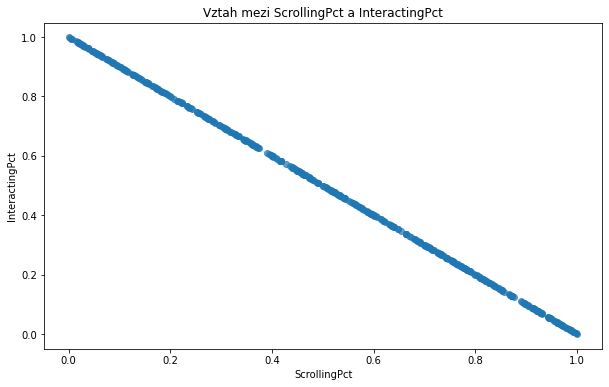

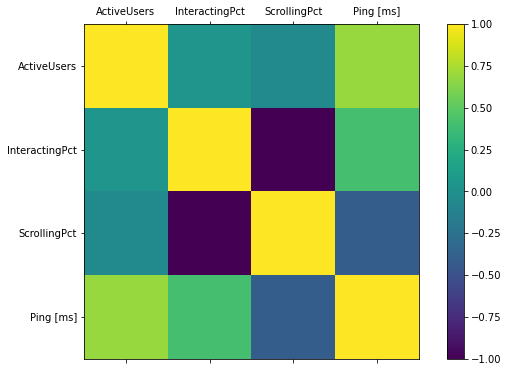

      OSType  ActiveUsers  ScrollingPct  Ping
0        iOS         4113        0.1717    47
1        iOS         7549        0.6539    46
2    Windows         8855        0.7822    55
3    Android         8870        0.9206    56
4      MacOS         9559        0.2718    76
..       ...          ...           ...   ...
497      iOS         5315        0.8026    28
498    MacOS         1392        0.7627    24
499      iOS         6014        0.1888    54
500  Android         5118        0.7655    39
501    MacOS         2660        0.0610    55

[502 rows x 4 columns]


In [15]:
# vztah mezi ScrollingPct a InteractingPct
plt.figure(figsize=(10, 6))
plt.scatter(data_task2['ScrollingPct'], data_task2['InteractingPct'], alpha=0.7)
plt.title('Vztah mezi ScrollingPct a InteractingPct')
plt.xlabel('ScrollingPct')
plt.ylabel('InteractingPct')
plt.show()

# korelacni matice numerickych atributu
numeric_variables = data_task2.select_dtypes(include=[np.number])
plt.figure(figsize=(10, 6))
plt.matshow(numeric_variables.corr(), fignum=1)
plt.xticks(range(len(numeric_variables.columns)), numeric_variables.columns)
plt.yticks(range(len(numeric_variables.columns)), numeric_variables.columns)
plt.colorbar()
plt.show()

# odstraneni ScrollingPct sloupce + prejmenovani Ping sloupce
data_task2 = data_task2.drop('InteractingPct', axis=1)
data_task2 = data_task2.rename(columns={'Ping [ms]': 'Ping'})
print(data_task2)

### Analýza odlehlých hodnot (vstupní data)

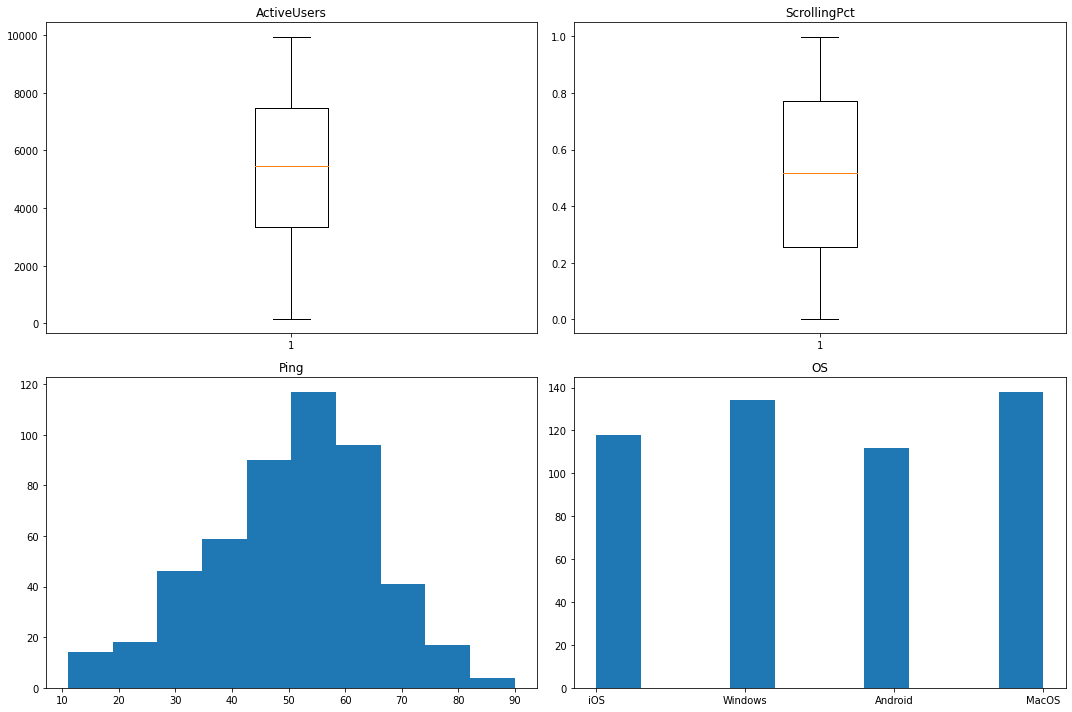

In [16]:
# Set up a subplot with 2 rows and 2 columns
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 10))

# Boxplot for ActiveUsers
axes[0, 0].boxplot(data_task2['ActiveUsers'])
axes[0, 0].set_title('ActiveUsers')

# Boxplot for ScrollingPct
axes[0, 1].boxplot(data_task2['ScrollingPct'])
axes[0, 1].set_title('ScrollingPct')

# plot distribution of Ping
axes[1, 0].hist(data_task2['Ping'])
axes[1, 0].set_title('Ping')

# Histogram for OS column
axes[1, 1].hist(data_task2['OSType'])
axes[1, 1].set_title('OS')

# Adjust layout to prevent overlapping
plt.tight_layout()

# Show the plot
plt.show()


### Zpětná eliminace plného kvadratického modelu a předpoklady lineární regrese

Výchozí plný kvadratický model je následujícího tvaru:
$
y= \beta_1 + \beta_2 \cdot OSType + \beta_3 \cdot ActiveUsers + \beta_4 \cdot InteractingPct + \beta_5 \cdot ScrollingPct + \beta_6 \cdot OSType \cdot ActiveUsers + \beta_7 \cdot OSType \cdot InteractingPct + \beta_8 \cdot OSType \cdot ScrollingPct + \beta_9 \cdot ActiveUsers \cdot InteractingPct + \beta_{10} \cdot ActiveUsers \cdot ScrollingPct + \beta_{11} \cdot InteractingPct \cdot ScrollingPct + \beta_{12} \cdot OSType^2 + \beta_{13} \cdot ActiveUsers^2 + \beta_{14} \cdot InteractingPct^2 + \beta_{15} \cdot ScrollingPct^2
$

Už nyní však víme, že jsme v předchozích krocích objevili lineární závislost mezi InteractingPct a ScrollingPct, ze zápisu modelu by se tedy odstranily všechny výrazy, ve kterých figuruje odstraněné InteractingPct.

Zároveň víme, že v zápisu pracujeme s 1 kategoriální proměnnou, kterou je třeba převést pomocí tzv. one-hot encoding na číselnou reprezentaci. Ze zdrojových dat vidíme, že kategorie může nabývat celkově 4 hodnot (typů OS), což nám rozšíří výchozí model. Již z tohoto však můžeme vytušit závislost, neboť 4. druh OS lze vypočítat z hodnot zbylých 3 hodnot pro OS. Podobně je zřejmé, že přidávat kvadratické atributy pro takto nově vzniklé hodnoty nedává smysl, neboť 0 i 1 umocněné na druhou stále zůstanou 0 a 1, a tedy do modelu nepřinesou žádnou zpřesňující informaci.

Po vzoru demonstračního cvičení normalizujeme data do rozsahu $\langle-1, 1 \rangle$. Podotkněme, že standardizace pouze převede hodnoty do zvoleného rozsahu, případné závislosti však zůstanou zachovány.

**Postupná manuální úprava regresního modelu**

K tomu, abychom určili vhodný submodel plného modelu,využijeme testu významnosti (nenulovosti) regresních parametrů $\beta_j$ pomocí statistik $t = \frac{\hat{\beta_j}}{S(\hat{\beta_j})}$, kde $\hat{\beta_j}$ je bodový odhad parametru $\beta_j$ a $S(\hat{\beta_j})$ je směrodatná chyba odhadu $\hat{\beta_j}$.

Testujeme hypotézu $H_0: \beta_j = 0$ oproti alternativní hypotéze $H_A: \beta_j \ne 0$

Pro postupné zjednodušení modelu vynecháme vždy ten parametr, u kterého jsme hypotézu nenulovosti nezamítli. Tyto statistky $t$, resp. $p$-hodnoty jsou uvedeny ve výstupu `model.summary()` (sloupec `t`, respektive `P>|t|`). Protože se v modelu nachází několik vyloučitelných regresních parametrů, vybereme vždy ten s nejvyšší $p$-hodnotou. V buňkách níže se postupně model zjednodušuje až do finální podoby, kde jsou všechny koeficienty významné. Cílem je, abychom nakonec skončili s co možná nejjednodušším modelem, který však bude poskytovat stejně dobré (a ideálně lepší) regresní odhady jako aktuální (výchozí) model

In [17]:
# https://www.statsmodels.org/stable/example_formulas.html
# https://stackoverflow.com/questions/55738056/using-categorical-variables-in-statsmodels-ols-class
# dummy variables pro OS sloupec (one-hot encoding) + prejmenovani (pro zjednoduseni prace)
data_task2 = pd.get_dummies(data_task2, columns=['OSType']).astype(float)
# rename columns Android, iOS, Windows, MacOS to Android, iOS, Windows, MacOS
data_task2 = data_task2.rename(columns={'OSType_Android': 'Android', 'OSType_iOS': 'iOS', 'OSType_Windows': 'Windows', 'OSType_MacOS': 'MacOS'})

# standardizace dat do rozsahu hodnot <-1,1>
# https://stackoverflow.com/questions/26414913/normalize-columns-of-pandas-data-frame
# min_value = data_task2.drop(['Ping'], axis=1).min(axis=0)
# max_value = data_task2.drop(['Ping'], axis=1).max(axis=0)
# data_task2 = (data_task2-min_value)/(max_value-min_value)*2-1

min_values = data_task2.drop(['Ping'], axis=1).min(axis=0)
max_values = data_task2.drop(['Ping'], axis=1).max(axis=0)
y_prediction_col =  data_task2.columns.drop('Ping')
data_task2[y_prediction_col] = (data_task2[y_prediction_col]-min_values)/(max_values - min_values)*2-1

# dalsi moznost normalizace
# dfS['ActiveUsers']=(dfS['ActiveUsers']-dfS['ActiveUsers'].mean())/dfS['ActiveUsers'].std() #odečti průměr a poděl směrodatnou odchylkou

Výchozí model očesán o atributy a jejich kombinace, jejichž (ne)důležitost byla diskutována v předešlých buňkách. Při každém odebrání atributu je důležité sledovat i ukazatele "kvality" modelu. Tím je v `model.summary()` položka R-squared, která je tím blíže k 1, čím lépe je křivka proložena daty (zjednodušeně řečeno).

In [18]:
model = smf.ols(formula="Ping ~ Android + MacOS + Windows + ActiveUsers + ScrollingPct + \
                        Android:ActiveUsers + Android:ScrollingPct + \
                        MacOS:ActiveUsers + MacOS:ScrollingPct + \
                        Windows:ActiveUsers + Windows:ScrollingPct + \
                        ActiveUsers:ScrollingPct + \
                        I(ActiveUsers*ActiveUsers) + I(ScrollingPct*ScrollingPct)", data=data_task2)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                   Ping   R-squared:                       0.844
Model:                            OLS   Adj. R-squared:                  0.839
Method:                 Least Squares   F-statistic:                     187.9
Date:                Thu, 14 Dec 2023   Prob (F-statistic):          5.18e-186
Time:                        14:04:56   Log-Likelihood:                -1598.4
No. Observations:                 502   AIC:                             3227.
Df Residuals:                     487   BIC:                             3290.
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
Intercept   

Ze souhrnu můžeme vyčíst:

**1. v horní části**
- `R-squared`: číslo mezi 0 a 1, čím blíže 1, tím více dané přímka vystihuje data, se kterými pracujeme (*podíl vysvětlené variability pomocí modelu*)
- `Adj. R-squared`: funguje stejně jako R-squared, navíc však penalizuje přidání sloupců do matice plánu
- `Prob (F-statistic)`: říká, že alespoň 1 koeficient, který je v modelu (kromě konstanty), je nenulový a zároveň je statisticky významný, tj. pomůže v tom, abychom modelovali hledanou proměnnou y
- další 3 hodnoty pak slouží spíše pro srovnání modelů mezi sebou

**2. ve střední části**
- každý řádek nám říká hodnotu prediktoru, který vyšel, k němu i test toho, že hodnota může být nulová
- test nám řekne, jestli může být hodnota prediktoru nulová a pokud ano, jak moc to změní kvalitu modelu
- u řádků, kde máme P>|t| rovno 0, víme, že hodnota prediktoru je důležitou součástí modelu

**3. v dolní části**
- `Omnibus` a `JB` testují normalitu reziduí a oba dva se spíše zaměřují na poruchy v šikmosti nebo špičatosti
- v případě, kdy máme hodně měření (tisíce), je lepší se orientovat dle JB (a příslušné Prob)
- `Durbin-Watson` dává dohromady nezávislost reziduí - pokud se rezidua nijak neovlivňují (jsou nezávislé), tak hodnota by měla být okolo 2
- `Cond. No.` je číslo podmíněnosti pro matici plánu; když začne být velké, znamená to, že malá změna ve vstupech způsobí velkou změnu v koeficientech


In [19]:
model = smf.ols(formula="Ping ~ Android + MacOS + Windows + ActiveUsers + ScrollingPct + \
                        Android:ActiveUsers + Android:ScrollingPct + \
                        MacOS:ActiveUsers + MacOS:ScrollingPct + \
                        Windows:ActiveUsers + \
                        ActiveUsers:ScrollingPct + \
                        I(ActiveUsers*ActiveUsers) + I(ScrollingPct*ScrollingPct)", data=data_task2)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                   Ping   R-squared:                       0.844
Model:                            OLS   Adj. R-squared:                  0.840
Method:                 Least Squares   F-statistic:                     202.8
Date:                Thu, 14 Dec 2023   Prob (F-statistic):          3.57e-187
Time:                        14:04:56   Log-Likelihood:                -1598.4
No. Observations:                 502   AIC:                             3225.
Df Residuals:                     488   BIC:                             3284.
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
Intercept   

In [20]:
model = smf.ols(formula="Ping ~ Android + MacOS + Windows + ActiveUsers + ScrollingPct + \
                        Android:ActiveUsers + \
                        MacOS:ActiveUsers + MacOS:ScrollingPct + \
                        Windows:ActiveUsers + \
                        ActiveUsers:ScrollingPct + \
                        I(ActiveUsers*ActiveUsers) + I(ScrollingPct*ScrollingPct)", data=data_task2)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                   Ping   R-squared:                       0.844
Model:                            OLS   Adj. R-squared:                  0.840
Method:                 Least Squares   F-statistic:                     220.1
Date:                Thu, 14 Dec 2023   Prob (F-statistic):          2.38e-188
Time:                        14:04:56   Log-Likelihood:                -1598.4
No. Observations:                 502   AIC:                             3223.
Df Residuals:                     489   BIC:                             3278.
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
Intercept   

In [21]:
model = smf.ols(formula="Ping ~ Android + MacOS + Windows + ActiveUsers + ScrollingPct + \
                        Android:ActiveUsers + \
                        MacOS:ActiveUsers + \
                        Windows:ActiveUsers + \
                        ActiveUsers:ScrollingPct + \
                        I(ActiveUsers*ActiveUsers) + I(ScrollingPct*ScrollingPct)", data=data_task2)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                   Ping   R-squared:                       0.844
Model:                            OLS   Adj. R-squared:                  0.840
Method:                 Least Squares   F-statistic:                     240.6
Date:                Thu, 14 Dec 2023   Prob (F-statistic):          1.57e-189
Time:                        14:04:56   Log-Likelihood:                -1598.5
No. Observations:                 502   AIC:                             3221.
Df Residuals:                     490   BIC:                             3272.
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
Intercept   

In [22]:
model = smf.ols(formula="Ping ~ Android + MacOS + Windows + ActiveUsers + ScrollingPct + \
                        Android:ActiveUsers + \
                        MacOS:ActiveUsers + \
                        ActiveUsers:ScrollingPct + \
                        I(ActiveUsers*ActiveUsers) + I(ScrollingPct*ScrollingPct)", data=data_task2)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                   Ping   R-squared:                       0.843
Model:                            OLS   Adj. R-squared:                  0.840
Method:                 Least Squares   F-statistic:                     264.5
Date:                Thu, 14 Dec 2023   Prob (F-statistic):          1.62e-190
Time:                        14:04:57   Log-Likelihood:                -1599.0
No. Observations:                 502   AIC:                             3220.
Df Residuals:                     491   BIC:                             3266.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
Intercept   

In [23]:
model = smf.ols(formula="Ping ~ Android + MacOS + Windows + ActiveUsers + ScrollingPct + \
                        Android:ActiveUsers + \
                        MacOS:ActiveUsers + \
                        ActiveUsers:ScrollingPct + \
                        I(ActiveUsers*ActiveUsers)", data=data_task2)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                   Ping   R-squared:                       0.843
Model:                            OLS   Adj. R-squared:                  0.840
Method:                 Least Squares   F-statistic:                     293.7
Date:                Thu, 14 Dec 2023   Prob (F-statistic):          1.62e-191
Time:                        14:04:57   Log-Likelihood:                -1599.6
No. Observations:                 502   AIC:                             3219.
Df Residuals:                     492   BIC:                             3261.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
Intercept       

V této fázi již žádný prediktor nemůžeme vyřadit, neboť jsou všechny pro model důležité. Dle koeficientu determinace (`R-squared`) můžeme učinit závěr, že odebrání vybraných prediktorů (koeficientů) nemělo žádný vliv na schopnost modelu predikovat. Výhodou však je, že jednodušší modely jsou schopné lépe generalizovat na dosud neviděných datech.

Statistika Durbin-Watson indikuje, že po sobě jdoucí rezidua mají minimální pozitivní autokorelaci, rezidua nejsou prakticky autokorelovaná a nijak se neovlivňují. Preferovaná hodnota je 2, které se blížíme.

Pro zjištění kolinearity ještě můžeme spočítat VIF. Když jsou prediktory perfektně nezávislé, je hodnota 1, do 10 je to v pořádku, nad 10 již máme to problém. 
Kormě VIF můžeme využít ještě korelační matici, ze které zjišťujeme, zdali je mezi prediktory nějaká lineární závislost, tj. modelu nic moc nepřinášejí, neboť je lze spočítat přímo.

                                   VIF
Intercept                     5.119102
Android                       1.589744
MacOS                         1.611049
Windows                       1.573735
ActiveUsers                   2.312895
ScrollingPct                  1.030747
Android:ActiveUsers           1.750854
MacOS:ActiveUsers             1.468371
ActiveUsers:ScrollingPct      1.034210
I(ActiveUsers * ActiveUsers)  1.138708


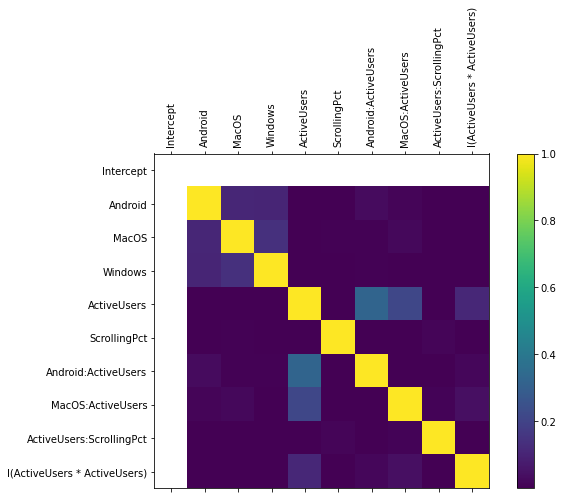

In [24]:
X = pd.DataFrame(model.exog, columns=model.exog_names)
vif = pd.Series([variance_inflation_factor(X.values, i) 
                 for i in range(X.shape[1])], 
                 index=X.columns)
vif_df = vif.to_frame()
# Nastavení názvu sloupce
vif_df.columns = ['VIF']
print(vif_df)
# korelacni matice druhych mocnin a text na horizontalni ose dat svisle, aby se vesel nazev sloupce
plt.figure(figsize=(10, 6))
plt.matshow(X.corr()**2, fignum=1)
plt.xticks(range(len(X.columns)), X.columns, rotation=90)
plt.yticks(range(len(X.columns)), X.columns)
plt.colorbar()
plt.show()

Vidíme, že žádná silná korelace není přítomna a VIF hodnoty jsou též pod 10, tedy v pořádku.

Z diagnostik jsme již tedy vyřešili:
- **ověření základních předpokladů MNČ (kritika metody)**:
ověření stejného rozptylu, ověření autokorelace (Durbin-Watson), ověření normality (Omnibus, Jarque-Bera (JB))
- **ověření vhodnosti modelu pro daná data (kritika modelu)**:
ověření, zda v datech je nějaká závislost (čištění dat v první fázi), ověření kvality modelu (R-squared)

V této části se zaměříme na **určení vhodnosti dat pro navržený regresní model** (tj. kritiku dat), kde určíme případné vlivné body.

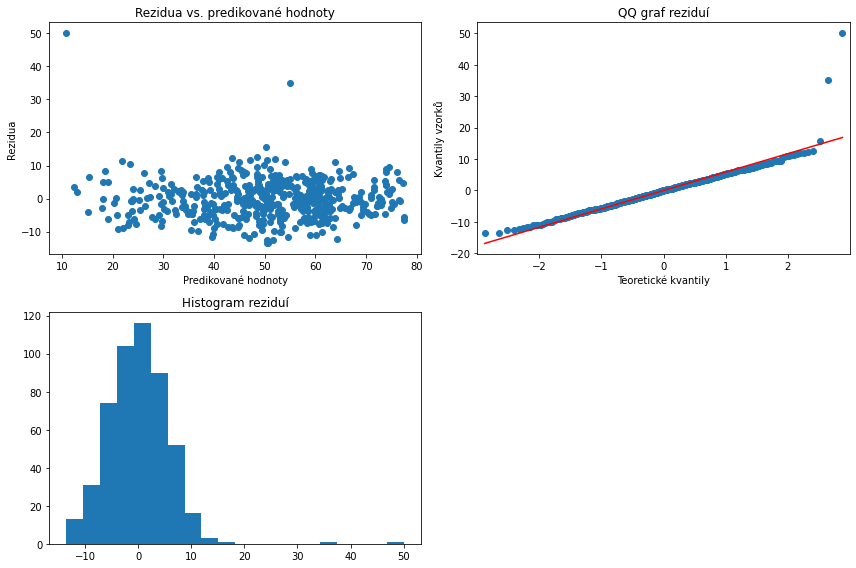

In [25]:
def plot_residuals():
    fig, axs = plt.subplots(2, 2, figsize=(12, 8))

    # Residuals vs. Fitted Values
    axs[0, 0].scatter(results.fittedvalues, results.resid)
    axs[0, 0].set_title('Rezidua vs. predikované hodnoty')
    axs[0, 0].set_xlabel('Predikované hodnoty')
    axs[0, 0].set_ylabel('Rezidua')

    # QQ graf rezidui
    sm.qqplot(results.resid, line='s', ax=axs[0, 1])
    axs[0, 1].set_title('QQ graf reziduí')
    axs[0, 1].set_xlabel('Teoretické kvantily')
    axs[0, 1].set_ylabel('Kvantily vzorků')


    # histogram rezidui
    axs[1, 0].hist(results.resid, bins=20)
    axs[1, 0].set_title('Histogram reziduí')

    # odstraneni prazdneho subplotu
    fig.delaxes(axs[1, 1])

    plt.tight_layout()
    plt.show()

plot_residuals()


Z grafů vidíme, že některá rezidua mají velké hodnoty a narušují nám normální rozdělení, a tím i kvalitu modelu. Identifikujeme řádky ve zdrojových datech a analyzujeme, zda se skutečně jedná o chybná data. Následně je odstraníme a na takto modifikovaných vstupních datech aktualizujeme zjednodušený model.

Pokud bychom chtěli používat i sofistikovanější metody pro odhalení odlehlých hodnot, můžeme k tomu využít např. Cookovu vzdálenost. Výstupy však byly podobné, jaké jsme zjistili z vizualizací.

255
ActiveUsers      0.093878
ScrollingPct     0.016732
Ping            90.000000
Android         -1.000000
MacOS           -1.000000
Windows          1.000000
iOS             -1.000000
Name: 255, dtype: float64

476
ActiveUsers     -1.000000
ScrollingPct     0.577998
Ping            61.000000
Android         -1.000000
MacOS            1.000000
Windows         -1.000000
iOS             -1.000000
Name: 476, dtype: float64

                            OLS Regression Results                            
Dep. Variable:                   Ping   R-squared:                       0.877
Model:                            OLS   Adj. R-squared:                  0.875
Method:                 Least Squares   F-statistic:                     388.1
Date:                Thu, 14 Dec 2023   Prob (F-statistic):          1.43e-216
Time:                        14:04:58   Log-Likelihood:                -1529.5
No. Observations:                 500   AIC:                             3079.
Df Residuals:        

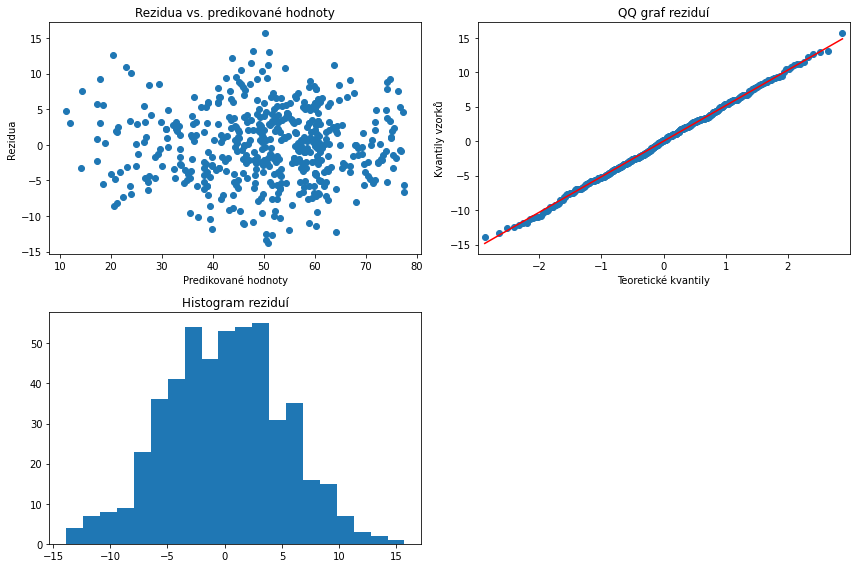

In [26]:
# identifikace odlehlych hodnot
outliers = results.resid[results.resid > 20]
for i in outliers.index:
    print(i)
    print(str(data_task2.iloc[i]) + "\n")

# odstraneni odlehlych hodnot
data_task2 = data_task2.drop(outliers.index)
data_task2 = data_task2.reset_index(drop=True)

model = smf.ols(formula="Ping ~ Android + MacOS + Windows + ActiveUsers + ScrollingPct + \
                        Android:ActiveUsers + \
                        MacOS:ActiveUsers + \
                        ActiveUsers:ScrollingPct + \
                        I(ActiveUsers*ActiveUsers)", data=data_task2)
results = model.fit()
print(results.summary())

plot_residuals()

Když si odlehlé hodnoty najdeme ve zdrojových datech, získáme hodnoty:

`MacOS 153 0,2111 0,7889 61`, což interpretujeme tak, že v daný moment bylo 153 na síti, z toho jen 21 % bylo aktivních (zbylých 100-21=79 % neaktivních), přesto dostáváme ping 61, což je nepřiměřeně vysoká hodnota a vymyká se od ostatních měření. 

Z druhého záznamu máme hodnoty: `Windows 5513 0,4912 0,5088	90`, což je obdobný případ jako výše, jen s vyššími hodnotami.

Z výstupů modelů pozorujeme, že metriky R-squared i Adj. R-squared se zlepšily. Z vizualizací též vidíme, že odlehlé hodnoty nejsou přítomny a nekazí model.

Než napíšeme výslednou rovnici modelu, vrátíme hodnoty z normalizované podoby do původní.

In [30]:
min_values = data_task2.drop(['Ping'], axis=1).min(axis=0)
max_values = data_task2.drop(['Ping'], axis=1).max(axis=0)
y_prediction_col =  data_task2.columns.drop('Ping')
data_task2[y_prediction_col] = (data_task2[y_prediction_col]-min_values)/(max_values - min_values)*2-1

In [31]:
data_task2

,ActiveUsers,ScrollingPct,Ping,Android,MacOS,Windows,iOS
0,-0.307658,-0.658752,47.0,-1.0,-1.0,-1.0,1.0
1,0.461711,0.307484,46.0,-1.0,-1.0,-1.0,1.0
2,0.754142,0.564573,55.0,-1.0,-1.0,1.0,-1.0
3,0.757501,0.841900,56.0,1.0,-1.0,-1.0,-1.0
4,0.911778,-0.458171,76.0,-1.0,1.0,-1.0,-1.0
...,...,...,...,...,...,...,...
495,-0.038513,0.605450,28.0,-1.0,-1.0,-1.0,1.0
496,-0.916928,0.525498,24.0,-1.0,1.0,-1.0,-1.0
497,0.118003,-0.624487,54.0,-1.0,-1.0,-1.0,1.0
498,-0.082624,0.531109,39.0,1.0,-1.0,-1.0,-1.0


In [64]:
# budeme zpet pracovat s puvodnimi hodnotami (nestandardizovane)
data_task2 = pd.read_excel('Projekt-2_Data.xlsx', sheet_name=1)
data_task2 = pd.get_dummies(data_task2, columns=['OSType']).astype(float)
data_task2 = data_task2.rename(columns={'OSType_Android': 'Android', 'OSType_iOS': 'iOS', 'OSType_Windows': 'Windows', 'OSType_MacOS': 'MacOS'})
data_task2 = data_task2.drop(['InteractingPct', 'iOS'], axis=1)
data_task2 = data_task2.rename(columns={'Ping [ms]': 'Ping'})
data_task2.drop([255, 476], inplace=True)

model = smf.ols(formula="Ping ~ Android + MacOS + Windows + ActiveUsers + ScrollingPct + \
                        Android:ActiveUsers + \
                        MacOS:ActiveUsers + \
                        ActiveUsers:ScrollingPct + \
                        I(ActiveUsers*ActiveUsers)", data=data_task2)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                   Ping   R-squared:                       0.877
Model:                            OLS   Adj. R-squared:                  0.875
Method:                 Least Squares   F-statistic:                     388.1
Date:                Thu, 14 Dec 2023   Prob (F-statistic):          1.43e-216
Time:                        14:42:11   Log-Likelihood:                -1529.5
No. Observations:                 500   AIC:                             3079.
Df Residuals:                     490   BIC:                             3121.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
Intercept       

Výsledná rovnice modelu tedy je:

$
y= \beta_1 + \beta_2 \cdot TODO
$

### Úloha 2_2: Nejproblematičtější hodnota

ty máš předpovědět, jaký je v dané situaci ping
a jde ti o to, aby ti model co nejlépe trefil to číslo, co je v tom excelu (ping) 
ne, že trefí to největší - u jednoho záznamu ten ping prostě největší bude 
tedy - máš dataframe se sloupcem ping (říkejme mu y)
a máš predikované hodnoty (říkejme tomu X)
vypočítáš si rezidua (y - X)
reziduum je rozdíl mezi skutečnou a predikovanou hodnotou
a to je to, co potřebuješ
tam ti model selhal, tam (při těchto vstupních parametrech - prediktorech) ti dává úplně jinou hodnotu, než je v tom excelu 
rezidua dáš do absolutní hodnoty (je ti jedno jestli to přestřelil nebo podstřelil, jde jenom o to, o kolik se liší) 
a vybereš index s nejvyšší hodnotou
toto podle mě chtěli

Taky mi spíš přišlo, že chtějí parametry, kde je nejvyšší ping - jakože chtějí předpovědět tu nejproblematičtější věc, co se může stát (například OS - Mac, 10000 ActiveUsers a ScrollingPct=1)
Ono totiž nejde pochopit jestli chtějí nejproblematičtější ping (tedy nejvyšší hodnotu), nebo nejproblematičtější část modelu (tedy největší chybovost modelu)

### Úloha 2_3: Odezva uživatele s Windows

In [155]:
# vypocet prumernych hodnot
numeric_variables = data_task2.select_dtypes(include=[np.number])
mean_numeric_values = numeric_variables.mean().drop('Ping')
# vytvoreni dataframe pro vstupni hodnoty
input_values = pd.DataFrame([mean_numeric_values])
# nastaveni atributu pro OS
input_values['Android'] = 0
input_values['MacOS'] = 0
input_values['iOS'] = 0
input_values['Windows'] = 1
print(f'Vstupní hodnoty pro model:\n{input_values.iloc[0]}')
# provedeni predikce
predicted_values = results.predict(input_values)
print(f'\nPredikovaná hodnota ping: {round(predicted_values[0], 2)}')

# pro overeni si vezmeme vsechny zaznamy Windows a spocitame prumerny ping
data_task2_initial = pd.read_excel('Projekt-2_Data.xlsx', sheet_name=1)
data_task2_initial.drop([255, 476], inplace=True)
data_windows = data_task2_initial[data_task2_initial['OSType'] == 'Windows']
data_windows['Ping [ms]'].mean()
print(f'Průměr hodnot ping pro Windows: {round(data_windows["Ping [ms]"].mean(), 2)}')

# vypocty intervalu
predictions = results.get_prediction(input_values)
pred = predictions.summary_frame(alpha=0.05) # 95% intervaly
print(f'Konfidenční interval: <{round(pred["mean_ci_lower"][0], 2)}, {round(pred["mean_ci_upper"][0], 2)}>')
print(f'Predikční interval: <{round(pred["obs_ci_lower"][0], 2)}, {round(pred["obs_ci_upper"][0], 2)}>')


Vstupní hodnoty pro model:
ActiveUsers     5496.442000
ScrollingPct       0.510837
Android            0.000000
MacOS              0.000000
Windows            1.000000
iOS                0.000000
Name: 0, dtype: float64

Predikovaná hodnota ping: 54.98
Průměr hodnot ping pro Windows: 51.43
Konfidenční interval: <53.95, 56.01>
Predikční interval: <44.69, 65.26>


### Úloha 2_4: Znovupoužitelnost modelu